# Important note

Please consider installing deepST as suggested in https://github.com/JiangBioLab/DeepST

# Purpose of the notebook

This notebook is used to identify domains using DeepST

In [5]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
os.chdir('/home/sergio/DeepST/DeepST-main/deepst') # this should be the location of your DEEPST repo
import os 
from DeepST import run
import matplotlib.pyplot as plt
from pathlib import Path
import scanpy as sc
import numpy as np

# now we change the directory to our original one. In our case:
os.chdir('/media/sergio/xenium_b_and_heart/Xenium_benchmarking-main/notebooks/7_domain_exploration')

# 

In [6]:
adata=sc.read('../../data/processed_adata/adata_multisection_nuclei_r1_with_annotations.h5ad')
adata.X=adata.layers['raw']
adata=adata[adata.obs['replicate']=='1']

In [7]:
adata.obsm['spatial']=np.array(adata.obs.loc[:,['x_centroid','y_centroid']])

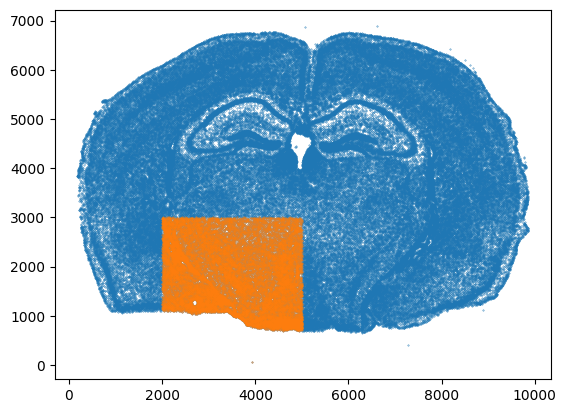

In [8]:
adata2=adata[(adata.obs['x_centroid']<5000)&(adata.obs['x_centroid']>2000)&(adata.obs['y_centroid']<3000)]
plt.scatter(adata.obs.loc[:,'x_centroid'],adata.obs.loc[:,'y_centroid'],s=0.1)
plt.scatter(adata2.obs.loc[:,'x_centroid'],adata2.obs.loc[:,'y_centroid'],s=0.1)
adata=adata2

In [9]:
ndoms=[]
for num in range(1,5):
    ndoms.append(len(np.unique(adata.obs['region_level'+str(num)])))

In [ ]:
save_path='..'
deepen = run(save_path = save_path,task = "Identify_Domain", pre_epochs = 800, epochs = 1000, use_gpu = True)
adata = deepen._get_augment(adata, spatial_type="BallTree", use_morphological=False)
###### Build graphs. "distType" includes "KDTree", "BallTree", "kneighbors_graph", "Radius", etc., see adj.py
graph_dict = deepen._get_graph(adata.obsm["spatial"], distType = "BallTree")


Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0


In [ ]:
data = deepen._data_process(adata, pca_n_comps = 200)

In [ ]:
deepst_embed = deepen._fit(data = data,graph_dict = graph_dict,)

In [19]:
ndoms

[5, 6, 10, 16]

Best resolution:  0.1


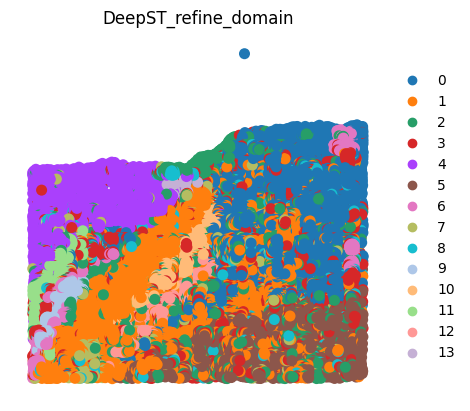

Best resolution:  0.1


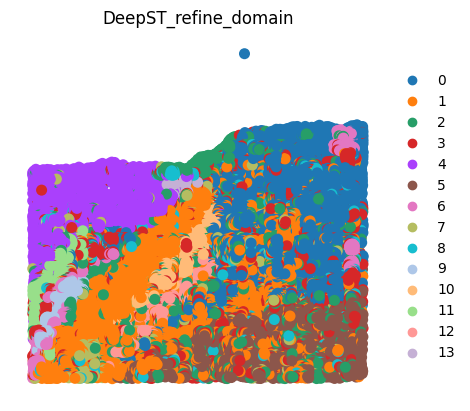

Best resolution:  0.1


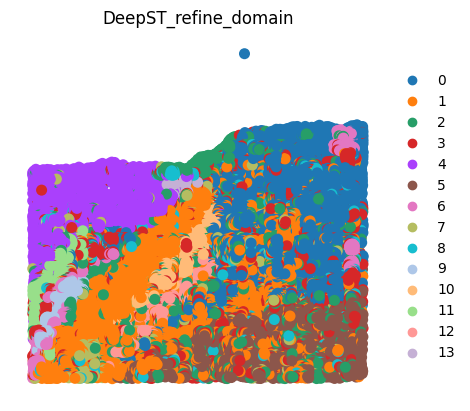

Best resolution:  0.17999999999999997


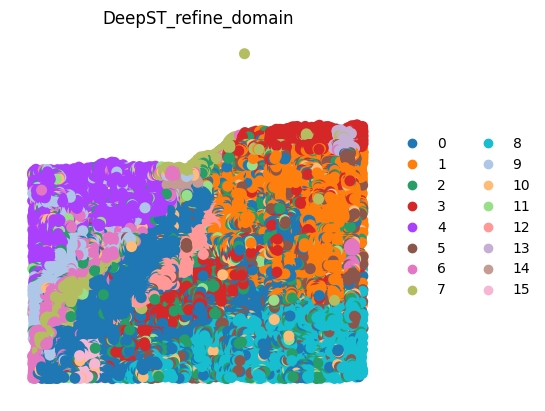

In [20]:
adata.obsm["DeepST_embed"] = deepst_embed
for n_domains in ndoms:
    ###### Define the number of space domains, and the model can also be customized. If it is a model custom priori = False.
    adata = deepen._get_cluster_data(adata, n_domains=n_domains, priori = True)
    ###### Spatial localization map of the spatial domain
    sc.pl.spatial(adata, color='DeepST_refine_domain', frameon = False, spot_size=100)
    #plt.savefig(os.path.join(save_path, f'{data_name}_domains.pdf'), bbox_inches='tight', dpi=300)
    results=adata.obs.loc[:,['cell_id','DeepST_refine_domain']]
    results.columns=['cell_id','spatial_domain']
    results.to_csv('../../figures/7.spatial_architecture/domains_predicted/ROI2/'+str(n_domains)+'/predicted_deepST.csv')